In [7]:
# First load all necessary modules
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import dask
import datetime, os, sys

try:
    import clif
    import clif.preprocessing as cpp
except:
    import sys

    sys.path.append("../../")
    # from eof import fingerprints
    import clif
    import clif.preprocessing as cpp

In [8]:
# load the averaged temperature data 6 years before and 6 after 1991
DATA_DIR = "../../../e3sm_data/fingerprint/"
data = xr.open_dataarray(os.path.join(DATA_DIR, "Temperature.nc"))
data

<xarray.DataArray 'T' (time: 144, plev: 37, lat: 24, lon: 48)>
[6137856 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -84.38 -77.09 -69.76 -62.43 ... 69.76 77.09 84.38
  * lon      (lon) float64 0.0 7.5 15.0 22.5 30.0 ... 330.0 337.5 345.0 352.5
  * plev     (plev) float64 1e+05 9.75e+04 9.5e+04 ... 300.0 200.0 100.0
  * time     (time) object 1985-02-01 00:00:00 ... 1997-01-01 00:00:00

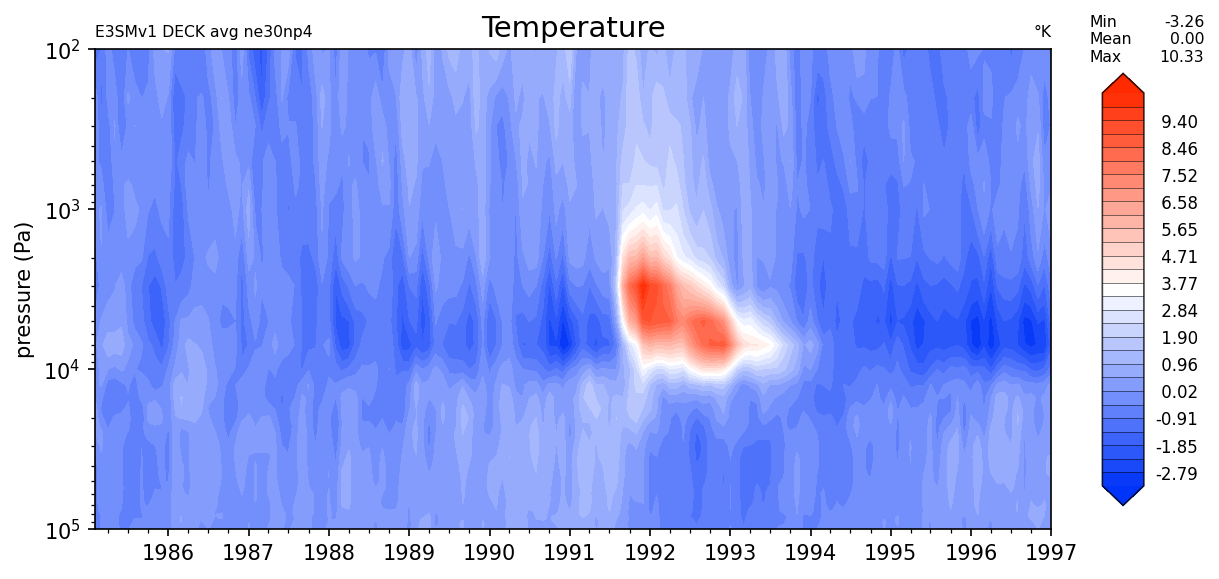

In [42]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    steps=[
        ("clip", cpp.ClipTransform(dims=["lat", "plev"], bounds=[(-60.0, 60.0), (-np.inf, np.inf)])),
        ("anom", cpp.SeasonalAnomalyTransform(cycle="month")),
        ("marginalize", cpp.MarginalizeOutTransform(dims=["lat", "lon"])),
        ("detrend", cpp.LinearDetrendTransform()),
        ("flatten", cpp.FlattenData(dims=["plev"])),
        ("transpose", cpp.Transpose(dims=["time", "plev"])),
        ("scale", cpp.ScalerTransform(scale_type="variance")),
    ]
)
data_new = pipe.fit_transform(data)


# import the lat lon contour plotting class
import clif.visualization as cviz

# Now we initialize the contout.plot_lat_lon class with some parameters like the color map and titles
clifplot1 = cviz.contour.plot_plev_time(
    cmap_name="e3sm_default_diff",
    title="Temperature",
    rhs_title=u"\u00b0" + "K",
    lhs_title="E3SMv1 DECK avg ne30np4",
)
clifplot1.show(data_new.T)

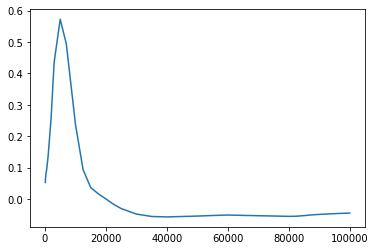

In [48]:
# get PCA fingerprints
##########################
# Begin fingerprinting and plotting EOF time-series scores
##########################
# Now we can begin calculating the EOFs
# obtain fingerprints
n_components = 8
fp = clif.fingerprints(n_eofs=n_components, varimax=False)
fp.fit(data_new)

# extract pca fingerprints and convergence diagnostics
eofs_pca = fp.eofs_
eof1 = eofs_pca[0]
plt.plot(data_new['plev'],eof1)

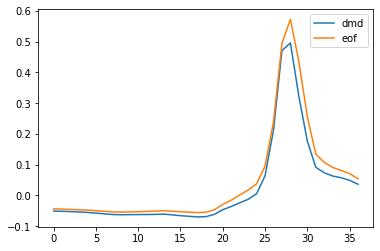

In [52]:
def dmd_direct(data: xr.DataArray):
    """Direct method for computing DMD without using SVD"""
    X_full = data.values
    X_full = X_full - np.mean(X_full, axis=0)  # mean center
    
    # Get X and X' DMD matrices
    X = X_full[:-1]
    Xp = X_full[1:]
    
    # Let's compute the full A matrix since it's so small
    # Solution A to minimize ||X - X'A||^2 where X' is the lagged data matrix
    A = np.linalg.pinv(X) @ Xp
    D,W = np.linalg.eig(A.T)
    
    return W.T
    
    
def dmd_kutz(data: xr.DataArray):
    """SVD-based method for computing DMD
    
    See Algorithm 1.1 in Kutz's DMD book
    
    Only difference is that our input matrix has snapshots in the row index. 
    Thus, all data matrices are transposed in Kutz's algorithm. This is to better
    align with ML and PCA. 
    """
    X_full = data.values
    X_full = X_full - np.mean(X_full, axis=0)  # mean center
    
    # Get X and X' DMD matrices
    X = X_full[:-1]
    Xp = X_full[1:]
    
    # Version Kutz (columnar vs row)
    U, S, Vt = np.linalg.svd(X.T, full_matrices=False)
    V = Vt.T
    
    # full rank
    r = 8 #U.shape[0] 
    
    # shortened matrices
    U_r = U[:, :r]
    S_r = S[:r]
    V_r = V[:, :r]
    
    Atilde = U_r.T @ Xp.T @ V_r @ np.diag(1.0 / S_r)
    D, W_r = np.linalg.eig(Atilde)
    Phi = Xp.T @ V_r @ np.diag(1.0 / S_r) @ W_r
    
    # return matrix where rows are the modes
    return Phi.T

dmd_modes = dmd_kutz(data_new)
dmd1 = dmd_modes[0]
plt.plot(-dmd1.real,label='dmd')
plt.plot(eof1,label='eof')
plt.legend()

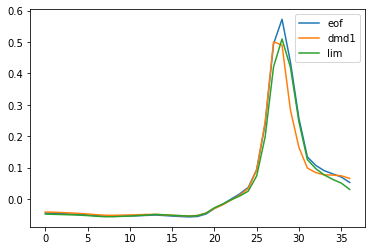

In [45]:
def lim_decomp(data: xr.DataArray):
    # Compute time-lagged covariance matrices as well
    X_full = data.values
    X_full = X_full - np.mean(X_full, axis=0)  # mean center

    # Get X and X' DMD matrices
    X = X_full[:-1]
    Xp = X_full[1:]

    m = X.shape[0]
    # compute covariance matrix
    C0 = (X.T @ X) / (m - 1)
    # compute time_lagged covariance matrix
    C1 = (X.T @ Xp) / (m - 1)
    # Combined
    Cnew = C1 @ np.linalg.inv(C0)
    wlim, Vlim = np.linalg.eig(Cnew)

    return Vlim.T

# get first DMD mode and projection
lim_modes = lim_decomp(data_new)
lim1 = np.real(lim_modes[0])
plt.plot(eof1,label='eof')
plt.plot(dmd1.real,label='dmd1')
plt.plot(lim1.real,label='lim')
plt.legend()
